In [39]:
import os
import random

import cv2
from PIL import Image
import numpy as np
import pandas as pd
from glob import glob

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import measure

### Test dataset

288개 (144개 폴더 * 좌, 우 두 개씩)

In [40]:
# 결과 불러오기
res_df = pd.read_csv('../result/output.csv')

# random으로 뽑기 위해 unique한 image_name을 뽑아냄 
uimg_names =  res_df['image_name'].unique().tolist()

# glob을 통해 img_path 전체를 받아오기
img_paths = glob(os.path.join("../data", "test", "*", "*", "*.png"))

In [41]:
# random으로 뽑은 image_name에 해당하는 img_path를 뽑아내기
path_dict = dict()
for img_path in img_paths:
    img_name = img_path.split("/")[-1]
    path_dict[img_name] = img_path

In [42]:
# random 추출
uimg_name = random.choice(uimg_names)

# 해당하는 img_path를 뽑아내기
img_path = path_dict[uimg_name]

# 해당하는 img의 결과값 뽑아내기
result = res_df[res_df['image_name'] == uimg_name]

In [43]:
# rle를 decode하는 함수를 정의합니다.
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

In [44]:
COLOR = {
    'finger': (120,203,228),
    'Trapezoid': (145,42,177),
    'Pisiform': (145,42,177),
    'Radius': (210,71,77),
    'Ulna': (210,71,77),
    'wrist': (193,223,159)
}

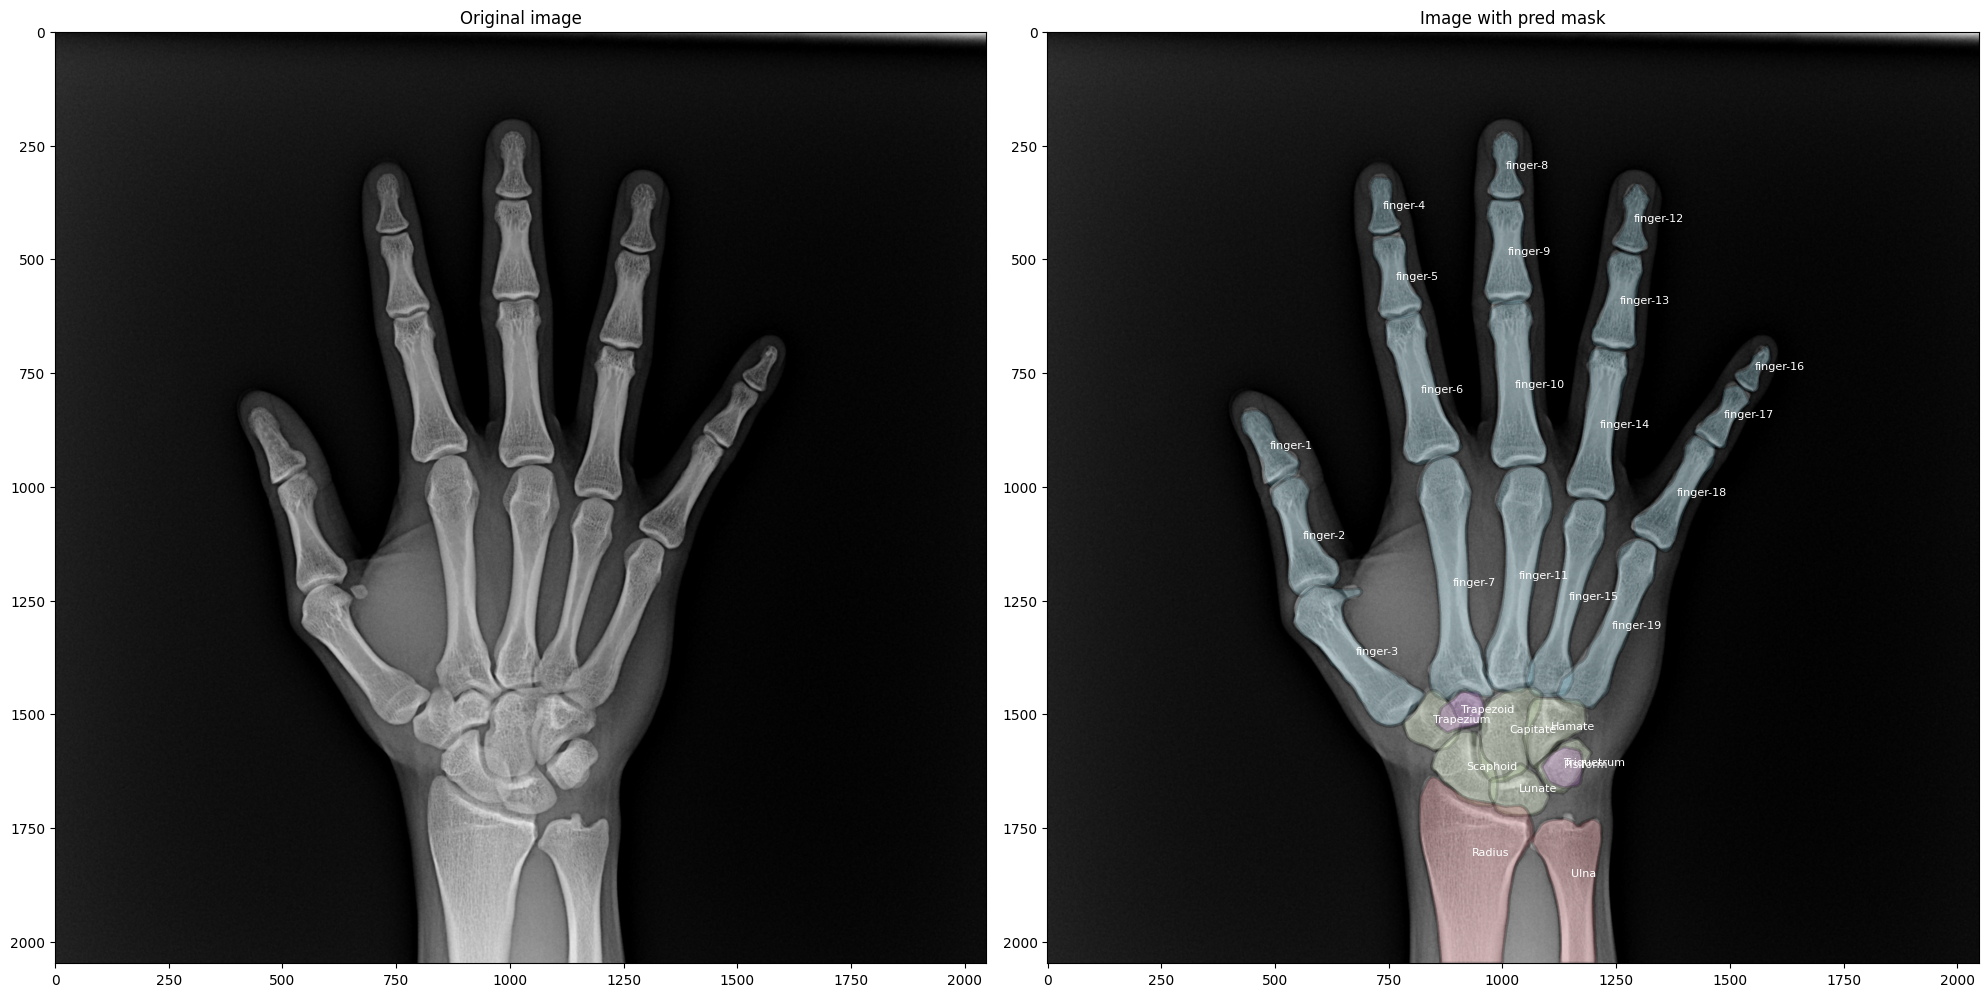

In [45]:
# 이미지를 불러옵니다.
img = Image.open(img_path).convert('RGB')
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(img)
axes[0].set_title('Original image')

axes[1].imshow(img)
axes[1].set_title('Image with pred mask')

for idx, res in enumerate(result.values):
    _, cls_name, rle = res
    # 디코딩을 진행합니다.
    # nan (못잡았을 때)이면 빈 마스크를 만듭니다.
    try:    
        decoded_rle = rle_decode(rle, (2048, 2048))*255
    except:
        decoded_rle = np.zeros((2048, 2048), dtype=np.uint8)*255
    
    # 클래스 이름 시각화를 위해 전처리를 진행합니다.
    origin_cls_name = cls_name
    if cls_name.startswith('finger'):
        cls_name = 'finger'
    elif cls_name not in COLOR:
        cls_name = 'wrist'
    
    # scikit-image 라이브러리를 활용하여 contour를 찾습니다.
    # scikit-image의 contour는 (y, x) 형태로 나오기 때문에, (x, y)로 변경해줍니다.
    contours = measure.find_contours(decoded_rle, 0.5)[0]
    contours = np.flip(contours, axis=1)
    
    # 찾은 contour를 시각화합니다.
    poly = patches.Polygon(
        contours, 
        closed=True, 
        facecolor=[ck/255 for ck in COLOR[cls_name]], 
        edgecolor='black', 
        linewidth=2,
        alpha=0.2
    )
    axes[1].add_patch(poly)
    
    # contour의 중심점을 찾아, 클래스 이름을 시각화합니다.
    cx, cy = sum([p[0] for p in contours]) / len(contours), sum([p[1] for p in contours]) / len(contours)
    axes[1].text(cx, cy, origin_cls_name, fontsize=8, color='white')
    
plt.tight_layout()
plt.show()    
    